# Imports

Import necessary libraries and modules including:
| Libraries | Version | Channel |
| ----------- | ----------- | ----------- |
| Matplotlib | 3.9.1 | conda-forge |
| NumPy | 2.2.2 | conda-forge |
| Matplotlib | 3.9.1 | conda-forge |
| Pandas | 2.2.3 | conda-forge |
| Pillow | 9.4.0 | conda-forge |
| Pytorch | 2.5.1 | conda-forge |
| Seaborn | 0.13.2 | conda-forge |
| Sklearn | 1.6.1 | conda-forge |

In [1]:
import import_ipynb
import importlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional  as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

from PIL import Image
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.io import read_image
from torchvision.transforms import ToTensor
from torchvision.transforms import v2

# Variables

For the sake of simpleness, the essentail constants are listed down below.

In [2]:
# Torch variables
SEED = 33

In [3]:
# Training varaibles
BATCH_SIZE = 32 # Number of images per batch
EPOCH = 50 # Epoch size
TRAIN_SIZE = 0.95 # 90 % of the training data is used for model training
VAL_SIZE = 0.05 # 10 % of the training data is used for model validation
LEARNING_RATE = 0.001 # Model's learning rate (default = 0.001)
NUM_WORKERS = 12 # Number of CPU cores used for dataloader
MOMENTUM = 0.9 # Momentum for optimizer
PATIENCE = 5 # Early stopping monitor patience

dataset_path = "../dataset"

# Image information
image_info = {
    # Both width and height are usually equal
    "width": 256,
    "height": 256
}

# Training data labels map
labels_map = {
    0: "Human",
    1: "AI"
}

In [4]:
# Display variables
display_figure_info = {
    "width": 12,
    "height": 12,
    "row": 3,
    "column": 3
}

In [5]:
# Current model
def get_current_model_path(new_model=False):
    count = 1

    while (True):
        if (os.path.isfile("../../trained_models/models/custom/trained_model_" + f"{count}" + ".pth") == False):
            if (new_model):
                return "../../trained_models/models/custom/trained_model_" + f"{count}" + ".pth"
            else:
                return "../../trained_models/models/custom/trained_model_" + f"{count - 1}" + ".pth"
        else:
            count += 1

In [6]:
current_model_path = get_current_model_path()

# Data Preprocessing

Preprocesssing
- Rescale (without cropping)
- Convert to RGB (for greyscale images)
- Image normalization

Augmentation
- Random horizontal flip (probability = 0.5)

In [7]:
torch.cuda.empty_cache() # Free CUDA cache memory
torch.manual_seed(SEED) # Assign Pytorch seed for reproducibility
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Initiate a CUDA device instance, if exists

In [8]:
# loading annotation files
train_csv = pd.read_csv("../dataset/train.csv")
test_csv = pd.read_csv("../dataset/test.csv")

In [9]:
train_csv.size

239850

In [10]:
train_csv.head()

,Unnamed: 0,file_name,label
0,0,train_data/a6dcb93f596a43249135678dfcfc17ea.jpg,1
1,1,train_data/041be3153810433ab146bc97d5af505c.jpg,0
2,2,train_data/615df26ce9494e5db2f70e57ce7a3a4f.jpg,1
3,3,train_data/8542fe161d9147be8e835e50c0de39cd.jpg,0
4,4,train_data/5d81fa12bc3b4cea8c94a6700a477cf2.jpg,1


In [11]:
test_csv.size

5540

In [12]:
test_csv.head()

,id
0,test_data_v2/1a2d9fd3e21b4266aea1f66b30aed157.jpg
1,test_data_v2/ab5df8f441fe4fbf9dc9c6baae699dc7.jpg
2,test_data_v2/eb364dd2dfe34feda0e52466b7ce7956.jpg
3,test_data_v2/f76c2580e9644d85a741a42c6f6b39c0.jpg
4,test_data_v2/a16495c578b7494683805484ca27cf9f.jpg


In [13]:
# Dataset class for training and validation
class CustomTrainImageDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.dataframe.iloc[idx, 0])
        image = Image.open(img_name).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
        
        label = self.dataframe.iloc[idx, 1]
        return image, label

# Dataset class for inference (validation and test)
class CustomTestImageDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, os.path.basename(img_path)

In [14]:
# Training augmentations
train_transforms = transforms.Compose([
    transforms.Lambda(lambda x: x.convert("RGB")),
    # transforms.RandomResizedCrop(225),
    transforms.Resize(size=(image_info["width"], image_info["height"])),
    transforms.RandomHorizontalFlip(),
    # transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.21, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Validation and Test transforms
val_test_transforms = transforms.Compose([
    transforms.Lambda(lambda x: x.convert("RGB")),
    transforms.Resize(size=(image_info["width"], image_info["height"])),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [15]:
# Preprocess column names for consistency
train_csv = train_csv[["file_name", "label"]]
train_csv.columns = ["id", "label"]

In [16]:
# Split the training data into training and validation sets
train_df, val_df = train_test_split(
    train_csv,  
    test_size=0.05,   
    stratify=train_csv["label"] 
)

In [17]:
# Display columns for reference
print("Train columns:", train_csv.columns)
print("Test columns:", test_csv.columns)

# Print shapes of the splits
print(f"\nTrain shape: {train_df.shape}")
print(f"Validation shape: {val_df.shape}")

# Check class distribution in both sets
print("\nTrain class distribution:")
print(train_df["label"].value_counts(normalize=True))

print("\nValidation class distribution:")
print(val_df["label"].value_counts(normalize=True))

Train columns: Index(['id', 'label'], dtype='object')
Test columns: Index(['id'], dtype='object')

Train shape: (75952, 2)
Validation shape: (3998, 2)

Train class distribution:
label
0    0.5
1    0.5
Name: proportion, dtype: float64

Validation class distribution:
label
1    0.5
0    0.5
Name: proportion, dtype: float64


In [18]:
# Create datasets
train_dataset = CustomTrainImageDataset(train_df, root_dir=dataset_path, transform=train_transforms)
val_dataset = CustomTrainImageDataset(val_df, root_dir=dataset_path, transform=val_test_transforms) 

# For testing, create a list of file paths (id)
test_file_list = [os.path.join(dataset_path, fname) for fname in test_csv["id"]]
test_dataset = CustomTestImageDataset(file_list=test_file_list, transform=val_test_transforms)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

In [19]:
image, label = train_dataset[0]

In [20]:
image.size()

torch.Size([3, 256, 256])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


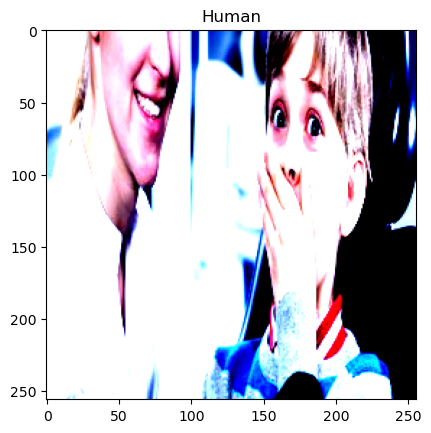

This image is generated by a human.


In [21]:
# Display the first training image
image_display = np.transpose(image, (1, 2, 0)) # Modify image shape to the correct format

plt.title(labels_map[label])
plt.imshow(image_display)
plt.show()

if (label):
    print("This image is generated by an AI.")
else:
    print("This image is generated by a human.")


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..2.2489083].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9980307..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9980307..2.5702832].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.64].
Clipping inp

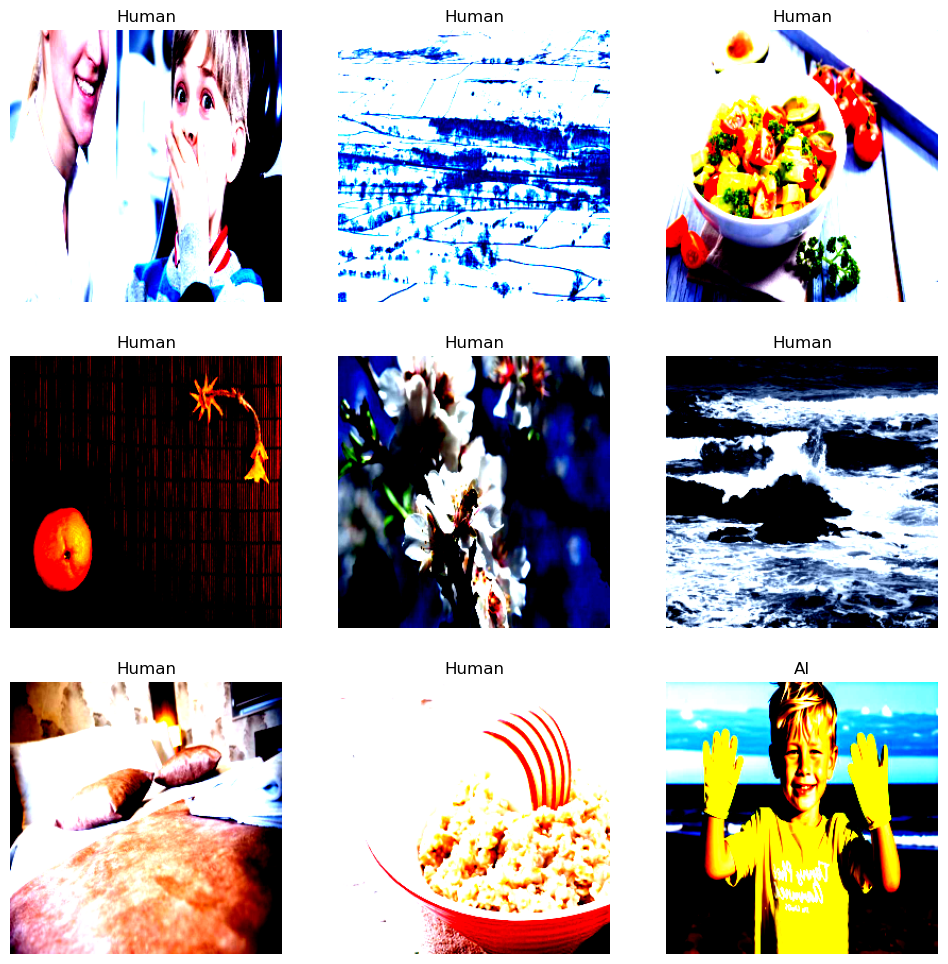

In [22]:
# Display raw images
figure = plt.figure(figsize=(display_figure_info["width"], display_figure_info["height"])) # initialize a new figure

for i in range(1, display_figure_info["column"] * display_figure_info["row"] + 1):
    image_index = (i - 1) % len(train_dataset)
    image, label = train_dataset[image_index]
    image = image.permute(1, 2, 0)

    figure.add_subplot(display_figure_info["row"], display_figure_info["column"], i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(image.squeeze(), cmap="gray")

plt.show()

In [23]:
# Load data
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

# Creating a Model

You can verify your GPU accerelation (CUDA) in test_GPU.ipynb.

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self, image_width, image_height):
        super().__init__()

        in_channels = 3  # RGB images
        out_channels_1 = 96  # Starting channels
        out_channels_2 = 384
        out_channels_3 = 192
        out_channels_4 = 768
        out_channels_5 = 1536
        out_channels_6 = 3072

        self.expansion = 1

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels, out_channels_1, kernel_size=4, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels_1)

        self.maxPool1 = nn.MaxPool2d(kernel_size=3, padding=0, stride=3)
        
        self.conv2 = nn.Conv2d(out_channels_1, out_channels_1, kernel_size=7, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels_1)

        self.conv3 = nn.Conv2d(out_channels_1, out_channels_2, kernel_size=1, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels_2)

        self.conv4 = nn.Conv2d(out_channels_2, out_channels_1, kernel_size=1, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(out_channels_1)

        self.conv5 = nn.Conv2d(out_channels_1, out_channels_3, kernel_size=2, padding=1, bias=False)
        self.bn5 = nn.BatchNorm2d(out_channels_3)

        self.conv6 = nn.Conv2d(out_channels_3, out_channels_4, kernel_size=7, padding=1, bias=False)
        self.bn6 = nn.BatchNorm2d(out_channels_4)

        self.conv7 = nn.Conv2d(out_channels_4, out_channels_3, kernel_size=1, padding=1, bias=False)
        self.bn7 = nn.BatchNorm2d(out_channels_3)

        self.conv8 = nn.Conv2d(out_channels_3, out_channels_3, kernel_size=1, padding=1, bias=False)
        self.bn8 = nn.BatchNorm2d(out_channels_3)

        # self.conv9 = nn.Conv2d(out_channels_3, out_channels_2, kernel_size=2, padding=2, bias=False)
        # self.bn9 = nn.BatchNorm2d(out_channels_2)

        # self.conv10 = nn.Conv2d(out_channels_2, out_channels_5, kernel_size=7, padding=2, bias=False)
        # self.bn10 = nn.BatchNorm2d(out_channels_5)

        # self.conv11 = nn.Conv2d(out_channels_5, out_channels_2, kernel_size=1, padding=2, bias=False)
        # self.bn11 = nn.BatchNorm2d(out_channels_2)

        # self.conv12 = nn.Conv2d(out_channels_2, out_channels_2, kernel_size=1, padding=2, bias=False)
        # self.bn12 = nn.BatchNorm2d(out_channels_2)

        # self.conv13 = nn.Conv2d(out_channels_2, out_channels_2, kernel_size=2, padding=2, bias=False)
        # self.bn13 = nn.BatchNorm2d(out_channels_2)

        # self.conv14 = nn.Conv2d(out_channels_2, out_channels_6, kernel_size=7, padding=2, bias=False)
        # self.bn14 = nn.BatchNorm2d(out_channels_6)
        
        # self.conv15 = nn.Conv2d(out_channels_6, out_channels_4, kernel_size=1, padding=2, bias=False)
        # self.bn15 = nn.BatchNorm2d(out_channels_4)

        self.conv16 = nn.Conv2d(out_channels_3, out_channels_1 * self.expansion, kernel_size=1, bias=False)
        self.bn16 = nn.BatchNorm2d(out_channels_1 * self.expansion)

        self.avgPool1 = nn.AvgPool2d(kernel_size=3, padding=0, stride=3)

        self.dropout = nn.Dropout(p=0.4)

        # Adjust shortcut to include pooling layers for spatial downsampling
        if in_channels != out_channels_1:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels_1 * self.expansion, kernel_size=1, bias=False),
                nn.MaxPool2d(kernel_size=3, padding=0, stride=3),
                nn.AvgPool2d(kernel_size=3, padding=0, stride=3)
            )
        else:
            self.shortcut = nn.Sequential(
                nn.MaxPool2d(kernel_size=3, padding=0, stride=3),
                nn.AvgPool2d(kernel_size=3, padding=0, stride=3)
            )

        # Compute flattened size dynamically
        with torch.no_grad():
            dummy_x = torch.randn(1, 3, image_width, image_height)  
            dummy_x = self._forward_conv(dummy_x)
            self.flattened_size = dummy_x.shape[1]  

        # Fully connected layers
        self.dense1 = nn.Linear(self.flattened_size, 1024)
        self.dense2 = nn.Linear(1024, 512)
        self.dense3 = nn.Linear(512, 256)
        self.dense4 = nn.Linear(256, 128)
        self.dense5 = nn.Linear(128, 2)

    def _forward_conv(self, x):
        residual = self.shortcut(x)  # Correctly downsampled residual

        x = F.relu(self.bn1(self.conv1(x)))
        x = self.maxPool1(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = F.relu(self.bn7(self.conv7(x)))
        x = F.relu(self.bn8(self.conv8(x)))
        # x = F.relu(self.bn9(self.conv9(x)))
        # x = F.relu(self.bn10(self.conv10(x)))
        # x = F.relu(self.bn11(self.conv11(x)))
        # x = F.relu(self.bn12(self.conv12(x)))
        # x = F.relu(self.bn13(self.conv13(x)))
        # x = F.relu(self.bn14(self.conv14(x)))
        # x = F.relu(self.bn15(self.conv15(x)))
        x = F.relu(self.bn16(self.conv16(x)))
        x = self.avgPool1(x)

        if residual.shape != x.shape:
            residual = F.interpolate(residual, size=x.shape[2:], mode='nearest') # or 'bilinear'

        x += residual  # Now x and residual have the same dimensions
        x = F.relu(x)  

        return torch.flatten(x, start_dim=1)  

    def forward(self, x):
        x = self._forward_conv(x)

        x = self.dropout(x)
        x = F.relu(self.dense1(x))
        x = self.dropout(x)
        x = F.relu(self.dense2(x))
        x = self.dropout(x)
        x = F.relu(self.dense3(x))
        x = self.dropout(x)
        x = F.relu(self.dense4(x))
        x = self.dropout(x)
        x = self.dense5(x)

        return x

# Data Preprocessing

In [25]:
# My custom model
model = NeuralNetwork(image_info["width"], image_info["height"]).to(device) # Use CUDA acceleration
loss_function = nn.CrossEntropyLoss() # Implement crossentropy loss
# optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4) # Initialize an optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = StepLR(optimizer, step_size=5, gamma=0.7)

In [26]:
# Early stopping monitor
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float("inf")
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [27]:
def train_loop(dataloader, model, loss_function, optimizer, val_dataloader=None, early_stopping=None, scheduler=None):
    model.train()
    
    all_predictions = [] # all predictions from the training model after each epoch
    all_labels = [] # all predictions from the training model after each epoch
    train_losses = [] # Array of training losses in each epoch
    lowest_val_loss = 1 # The lowest validation loss after an epoch
    val_losses = [] # Array of validation losses for plotting graph
    val_accuracies = [] # Array of validation accuracies for plotting graph

    current_model_path = get_current_model_path(new_model=True)

    progress_bar_length = 64 # Total number of "#" in the progress bar
    
    for epoch in range(EPOCH):
        progress_accumulated = 0.0 # Fractional progress tracker
        total_hashes = 0 # Total "#" printed so far

        print(f"Training epoch: {epoch + 1}")
        
        running_loss = 0.0
        correct = 0
        total = 0
        
        for i, data in enumerate(dataloader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            # Collecting labels and predictions for classification report
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Update progress bar
            progress_accumulated, total_hashes = progress_bar(
                dataloader, progress_accumulated, total_hashes, progress_bar_length
            )

        # After epoch completes, ensure the progress bar shows 100%
        if total_hashes < progress_bar_length:
            bar = "#" * progress_bar_length
            print(f"Completion (100.00%) : [{bar}]", flush=True)
        else:
            print()  # Move to new line

        epoch_loss = running_loss / len(dataloader)
        accuracy = 100 * correct / total
        
        # Save epoch loss and accuracy
        train_losses.append(epoch_loss)
        
        print(f"\nTraining Loss: {epoch_loss:.4f}, Training Accuracy: {accuracy:.2f}%")
        
        if val_dataloader:
            val_loss, val_accuracy = validate_model(val_dataloader, model, loss_function)
            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy)

            print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

            save_best_model(lowest_val_loss, val_loss, current_model_path)

            if (val_loss <= lowest_val_loss):
                lowest_val_loss = val_loss

            if early_stopping:
                early_stopping(val_loss)
                if early_stopping.early_stop:
                    print("Early stopping triggered.")
                    break
                
        # Call the scheduler to update the learning rate after each epoch
        if scheduler:
            scheduler.step()

        print("\n", end="\r")

    if val_dataloader:
        return train_losses, all_predictions, all_labels, val_losses, val_accuracies
    else:
        return train_losses, all_predictions, all_labels

def validate_model(dataloader, model, loss_function):
    model.eval()
    
    correct = 0
    total = 0
    val_loss = 0.0  
    
    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            val_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = 100 * correct / total
    
    return val_loss / len(dataloader), accuracy

def progress_bar(dataloader, accumulated, total_hashes, progress_bar_length):
    total_batches = len(dataloader)
    if total_batches == 0:
        return accumulated, total_hashes
    
    # Calculate progress increment per batch
    progress_per_batch = progress_bar_length / total_batches
    accumulated += progress_per_batch # Add progress for current batch
    
    num_prints = int(accumulated) # Number of "#" to add now
    if num_prints > 0:
        total_hashes += num_prints
        accumulated -= num_prints # Reset accumulated
        
        # Cap at 100% to avoid overshooting
        if total_hashes > progress_bar_length:
            total_hashes = progress_bar_length
        
        # Calculate percentage and print
        percentage = (total_hashes / progress_bar_length) * 100
        bar = "=" * (total_hashes - 1)

        print(f"Completion ({percentage:.2f}%) : [{bar}>]", end="\r", flush=True)
    
    return accumulated, total_hashes

# If the file exists already, change the number behind the file
def save_best_model(lowest_val_loss, current_val_loss, current_model_path):
    if (current_val_loss < lowest_val_loss):
        torch.save(model.state_dict(), current_model_path) # save the trained model

In [28]:
torch.cuda.empty_cache() # Free CUDA cache memory

if val_dataloader:
    epoch_losses, all_preds, all_labels, val_losses, val_accuracies = train_loop(
        dataloader=train_loader,
        model=model,
        loss_function=loss_function,
        optimizer=optimizer,
        val_dataloader=val_loader,
        early_stopping=EarlyStopping(patience=PATIENCE),
        scheduler=scheduler
    )
else:   
    epoch_losses, all_preds, all_labels = train_loop(
        dataloader=train_loader,
        model=model,
        loss_function=loss_function,
        optimizer=optimizer,
        early_stopping=EarlyStopping(patience=PATIENCE),
        scheduler=scheduler
    )

Training epoch: 1


OutOfMemoryError: CUDA out of memory. Tried to allocate 1.39 GiB. GPU 0 has a total capacity of 15.58 GiB of which 708.75 MiB is free. Process 43040 has 156.00 MiB memory in use. Including non-PyTorch memory, this process has 12.90 GiB memory in use. Of the allocated memory 10.65 GiB is allocated by PyTorch, and 2.09 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

# Evaluating the Model

Evaluate and visualize the trained model's performance using validation set.

In [ ]:
current_model_path = get_current_model_path()

In [ ]:
model = NeuralNetwork(image_info["width"], image_info["height"]) # define a new neural network instance
model.load_state_dict(torch.load(current_model_path)) # load the trained model
model = model.to(device)

In [ ]:
correct = 0 # number of correct predictions
total = 0 # number of total predictions

In [ ]:
def load_image(image_path):
    image = Image.open(image_path)
    image = val_test_transforms(image)
    image = image.unsqueeze(0)

    return image.to(device)

In [ ]:
test_image_paths = [
    "../../res/test_images/test_1.jpg",
    "../../res/test_images/test_2.jpg",
    "../../res/test_images/test_3.jpg",
    "../../res/test_images/test_4.jpg",
    "../../res/test_images/test_5.jpg",
    "../../res/test_images/test_6.jpg",
    "../../res/test_images/test_7.jpg",
    "../../res/test_images/test_8.jpg",
    "../../res/test_images/test_9.jpg",
]

images = [load_image(img) for img in test_image_paths]

In [ ]:
model.eval()
prediction_labels = []

with torch.no_grad():
    for img in images:
        outputs = model(img)
        _, predicted = torch.max(outputs, 1)
        prediction_labels.append(predicted.item())

In [ ]:
figure = plt.figure(figsize=(display_figure_info["width"], display_figure_info["height"]))

for i in range(1, display_figure_info["row"] * display_figure_info["column"] + 1):
    image_index = (i - 1) % len(images)
    image = images[image_index].cpu().squeeze(0).permute(1, 2, 0)
    label = prediction_labels[image_index]

    figure.add_subplot(display_figure_info["row"], display_figure_info["column"], i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(image)

plt.show()

In [ ]:
# Loss graph
plt.figure(figsize=(10, 6))
plt.plot(epoch_losses, label="Training Loss") # Training loss
plt.plot(val_losses, label="Validation Loss") # Validation loss
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

count = 1

while (True):
    if (os.path.isfile("../../trained_models/models/custom/trained_model_" + f"{count}" + ".pth") == False):
        plt.savefig("../../trained_models/evaluation_results/custom/model_" + f"{count - 1}" + "_training_loss.png") # Save the graph
        break
    else:
        count += 1

plt.show()

# Accuracy graph
plt.figure(figsize=(10, 6))
plt.plot(val_accuracies, label="Validation Accuracy") # Validation accuracy
plt.title("Validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

count = 1

while (True):
    if (os.path.isfile("../../trained_models/models/custom/trained_model_" + f"{count}" + ".pth") == False):
        plt.savefig("../../trained_models/evaluation_results/custom/model_" + f"{count - 1}" + "_validation_accuracy.png") # Save the graph
        break
    else:
        count += 1

plt.show()

# Calculate the accuracy for the entire training set
train_accuracy = 100 * sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)

print(f"Final Training Accuracy: {train_accuracy:.2f}%")


In [ ]:
# Classification report
train_report = classification_report(all_labels, all_preds, target_names=[labels_map[i] for i in labels_map])

print("Classification Report:\n", train_report)

# Confusion matrix
cf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 5))
sns.heatmap(cf_matrix, annot=True, annot_kws={"size": 18}, cmap="Spectral")
plt.ylabel('True')
plt.xlabel('Predicted')

count = 1

while (True):
    if (os.path.isfile("../../trained_models/models/custom/trained_model_" + f"{count}" + ".pth") == False):
        plt.savefig("../../trained_models/evaluation_results/custom/model_" + f"{count - 1}" + "_classification_report.png") # Save the graph
        break
    else:
        count += 1

plt.show()

# Generate submission file

Create a submission.csv file from the current model.

In [ ]:
# Load the trained neural network
model = NeuralNetwork(image_info["width"], image_info["height"]) # Define a new neural network instance
model.load_state_dict(torch.load(current_model_path)) # Load the trained model
model = model.to(device)

In [ ]:
predictions = [] # A list for storing the results

In [ ]:
def reverse_prediction(pred_label):
    if (pred_label == 0):
        return 1
    elif (pred_label == 1):
        return 0

In [ ]:
# Open a new CSV file for writing predictions
with open("../../submission/submission.csv", "w") as submission_file:
    # Write the header
    submission_file.write("id,label\n")

    model.eval()  # Set the model to evaluation mode
    
    with torch.no_grad():
        ids = []  # Initialize the list to hold image IDs
        predictions = []  # Initialize the list for predictions
        
        for data in test_dataloader:
            inputs = data[0]
            inputs = inputs.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            # Map predictions to labels
            batch_predictions = [labels_map[p.item()] for p in predicted]
            batch_ids = [("test_data_v2/" + image_id) for image_id in data[1]]  # Collect image IDs from the batch
            
            # Append the current batch's predictions and ids
            ids.extend(batch_ids)
            predictions.extend(predicted)

        # Write each prediction to the file
        for img_id, pred_label in zip(ids, predictions):
            pred_label = reverse_prediction(pred_label)
            submission_file.write(f"{img_id},{pred_label}\n")

print("Submission file has been created successfully!")
